In [34]:
import xarray as xr
import numpy as np
from glob import glob
import os
import subprocess
import warnings

import shlex
import re

from collections import namedtuple

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
class BashParser:
    """ Parse a bash script to extract variables
    """
    
    def __init__(self, script):
        self.script = script
        self._lines = []
        self.variables = dict()
        
    def _readlines(self):
        if not os.path.isfile(self.script):
            warnings.warn(f'{self.script} does not exist')
            return
        with open(self.script) as FILE:
            self._lines = FILE.readlines()
    
    def _strip_lines(self):
        """Drop comment lines, blank lines, and whitespace from self._lines"""
        if not self._lines:
            self._readlines()
        self._lines = [line.strip() for line in self._lines 
                       if line[0] != "#" and line != '\n']
    
    def _expand_var(self, var, do_eval=True):
        """ expand ${var}, $var, or `var` into what it should be """

        # patterns to match ${var} or $var
        pattern = '(\$\{[a-zA-Z0-9_]*\}|\$[a-zA-Z0-9_]*)'
        
        var = var.split('#')[0].strip()
        keys = re.findall(pattern, var)
        for key in keys:
            stripped_key = key
            for char in '${}':
                stripped_key = stripped_key.replace(char, '')
            if stripped_key in self.variables.keys():
                var = var.replace(key, self.variables[stripped_key])
            elif stripped_key == 'PWD':
                # special case: PWD refers to script directory
                var = var.replace(key, os.path.split(self.script)[0])
            elif stripped_key in os.environ:
                var = var.replace(key, os.environ[stripped_key])
        
        if do_eval and '`' in var:
            exprs = re.findall('`([^`]*)`', var)
            # evaluate each expression and replace
            for expr in exprs:
                args = expr.split()
                output = subprocess.run(args, capture_output=True).stdout.decode().strip()
                var = var.replace(f'`{expr}`', output)
        return var
    
    def _expand_conditional(self, line):
        """ expand 'if [ cond ]; then' and evaluate cond"""
        pattern = '(\$\{[a-zA-Z0-9_]*\}|\$[a-zA-Z0-9_]*)'
        keys = re.findall(pattern, line)
        for key in keys:
            stripped_key = key
            for char in '${}':
                stripped_key = stripped_key.replace(char, '')
            if stripped_key in self.variables.keys():
                line = line.replace(key, self.variables[stripped_key])
            elif stripped_key in os.environ:
                line = line.replace(key, os.environ[stripped_key])

        # drop everything except the conditional to be evaluated:
        # all have form '"a" == "b"' ...
        line_as_list = line.split()
        eq_pos = line_as_list.index('==')
        cond = line_as_list[eq_pos - 1] == line_as_list[eq_pos + 1]
        return line, cond
    
    def parse(self, verbose=False):
        if not self._lines:
            self._strip_lines()

        do_parse = True
        for i, line in enumerate(self._lines):
            # check for conditional
            if line.lstrip()[0:2] == 'if':
                # conditional line starts now -- if it evals to true, then continue parse. 
                # Else, skip to the next conditional
                new_line, do_parse = self._expand_conditional(line)
                if verbose:
                    if do_parse:
                        print('we have a match!', new_line)
                    else:
                        print('skipping ...', new_line)
            elif line.lstrip() == 'fi':
                # exiting conditional - return to parsing
                do_parse = True
                if verbose:
                    print(i, 'out of if block')
            if not do_parse:
                continue
            # commence parsing
            if '=' in line and '==' not in line:
                k, v = line.strip().split('=')
                self.variables[k] = self._expand_var(v)
        return self.variables

## Verify files have been generated
Goal of this notebook: provide a way to verify files have been verified

In [41]:
script_dir = '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm'
glob(f'{script_dir}/*.sh')

['/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/create_atm_initial_condition.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/generate_initial_mesh.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/generate_topo.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/generate_domain_files.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/do_it_all.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/slurm_gen_atmsrf.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/generate_atmsrf.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/generate_mapping_files.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/config.sh',
 '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/slurm_gen_topo.sh']

In [5]:
BashParser(f'{script_dir}/config.sh').parse()

{'project': 'm3525',
 'script_dir': '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm',
 'tempest_root': '/global/homes/c/crjones/git_repos/tempestremap',
 'squadgen_root': '/global/homes/c/crjones/git_repos/SQuadgen',
 'inputdata_root': '/global/cfs/cdirs/e3sm/inputdata',
 'e3sm_root': '/global/homes/c/crjones/git_repos/E3SM',
 'hiccup_root': '/global/homes/c/crjones/git_repos/HICCUP',
 'mapping_root': '/project/projectdirs/e3sm/mapping',
 'dyn_grid_name': 'enax32v2',
 'atm_grid_name': 'enax32v2pg2',
 'ocn_grid_name': 'oRRS18to6v3',
 'lnd_grid_name': 'r05',
 'refine_file': '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/meshes/refinement_patch_v2.png',
 'refine_level': '5',
 'date': '20211209',
 'output_root': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2',
 'lnd_grid_file': '/global/cfs/cdirs/e3sm/inputdata/lnd/clm2/mappingdata/grids/SCRIPgrid_0.5x0.5_nomask_c110308.nc',
 'lnd_scrip_file': '/global/cfs/cdirs/e3sm/inputdata/lnd/clm2/mappingdata/grids/SCRIPgrid_0.5x0.5_nomas

In [55]:
dummy = {'a': 'hi', 'b': 'bar'}
for k in dummy:
    print(k)

a
b


In [56]:
def verbose_print(msg, verbose=True):
    if verbose:
        print(msg)

class RRMHelper:
    Links = namedtuple('Links', ['script', 'files', 'gen_func', 'kwargs'],
                       defaults=[None, None, None, None])
    
    def __repr__(self):
        return f'RRMHelper({self.script_dir}, {self.config_script})'
    
    def __init__(self, script_dir='', config_script='config.sh'):
        self.script_dir = script_dir
        self.config_script = config_script
        self.variables = BashParser(f'{script_dir}/{config_script}').parse()
        self.mesh_files = self._gen_mesh_files()
        self.map_files = self._gen_map_files()
        self.domain_files = self._gen_domain_files()
        self.topography_file = self._gen_topography_file()
        self.dry_deposition_file = self._gen_dry_deposition_file()
        self.dry_deposition_aux_files = self._gen_dry_deposition_aux_files()
        self.topography_aux_files = self._gen_topography_aux_files()
        self.atm_ic = self._gen_atm_ic()
        self.output = self.check_output()
        self._links = {'mesh': RRMHelper.Links('generate_initial_mesh.sh', self.mesh_files, self._gen_mesh_files),
                       'map': RRMHelper.Links('generate_mapping_files.sh', self.map_files, self._gen_map_files, ['date']),
                       'domain': RRMHelper.Links('generate_domain_files.sh', self.domain_files, self._gen_domain_files, ['date']),
                       'topo': RRMHelper.Links('generate_topo.sh', self.topography_file, self._gen_topography_file),
                       'dry_dep': RRMHelper.Links('generate_atmsrf.sh', self.dry_deposition_file, self._gen_dry_deposition_file, ['date']),
                       'topo_aux': RRMHelper.Links('generate_topo.sh', self.topography_aux_files, self._gen_topography_aux_files),
                       'dry_dep_aux': RRMHelper.Links('generate_atmsrf.sh', self.dry_deposition_aux_files, self._gen_dry_deposition_aux_files, ['date']),
                       'atm_ic': RRMHelper.Links('create_atm_initial_condition.sh', self.atm_ic, self._gen_atm_ic, ['ic_date'])}
        self.dependencies = {'mesh': None,
                             'map': 'mesh',
                             'domain': ('mesh', 'map'),
                             'topo': 'mesh',
                             'dry_dep': 'mesh',
                             'topo_aux': 'mesh',
                             'dry_dep_aux': 'mesh',
                             'atm_ic': ('mesh', 'topo')}
    
    def get_runscript(self, name):
        return f'{self.script_dir}/{self._links[name].script}'
        
    def check_output(self, verbose=False):
        # use get method to gracefully fail if output_root doesn't exist
        output_contents = glob(f'{self.variables.get("output_root")}/*')
        if verbose:
            print(f'Contents of output directory {self.variables.get("output_root")}:')
            print(*sorted(output_contents), sep='\n')
        return output_contents
        
    def _check_for_alternate_date(self, link, date_match='latest'):
        """Use link info to check if other file exists with alternate date"""
        if not link.kwargs:
            print(f'No kwargs for {link.gen_func}')
            return link.files
        # check for alternate dates by inserting '!':
        kwargs = {key: '!' for key in link.kwargs}
        test_files = link.gen_func(**kwargs)  # this is a dictionary
        # strip off date
        pos_dict = {key: test.find('!') for key, test in test_files.items()}
        # print(pos_dict)
        
        # regex patterns should match yymmdd, yyyymmdd, yyyy-mm-dd, yy-mm-dd
        patterns = {key: f'{test_files[key][:pos]}[\d\-]*{test_files[key][pos+1:]}'
                    for key, pos in pos_dict.items()}
        # print('Patterns', patterns, sep='\n')
        matches = {key: self._search_path_for_alt_dates(patt) for key, patt in patterns.items()}
        # print('Matches', matches, sep='\n')
        if date_match == 'latest':
            # print(link.files)
            return {key: match[-1] if match else link.files[key] for key, match in matches.items()}
        else:
            return link.files
    
    def _search_path_for_alt_dates(self, pattern):
        matches = []
        for f in self.output:
            x = re.match(pattern, f)
            if x is not None:
                matches.append(x.group())
        return sorted(matches)
    
    def check_for_output_files(self, step, date_match='latest', update_output=False, verbose=True):
        links = self._links[step]
        verbose_print(step, verbose=verbose)
        if all(v in self.output for v in links.files.values()):
            # found!
            verbose_print(f'All {step} files found', verbose=verbose)
            return True
        else:
            if verbose:
                print(f'Some {step} files missing')
                for v in links.files.values():
                    print(v, v in self.output)
            if date_match == 'latest':
                verbose_print('Searching for other dates', verbose=verbose)
                out = self._check_for_alternate_date(links, date_match=date_match)
                if update_output:
                    verbose_print('Updating output files', verbose=verbose)
                    links.files.update(out)
                if all(v in self.output for v in out.values()):
                    verbose_print(f'All {step} files found with different dates', verbose=verbose)
                    return True
        return False
        
    def _locate_files(self, date_match='latest', update_output=False, verbose=True):
        """Check output directory to see if files exist"""
        kwargs = {'date_match': date_match, 'update_output': update_output, 'verbose': verbose}
        success = {key: self.check_for_output_files(key, **kwargs)
        verbose_print(success, verbose=verbose)
        return success
            
        
    def _locate_files_orig(self, date_match='latest', update_output=False):
        """Check output directory to see if files exist"""
        for key, links in self._links.items():
            print(key)
            if all(v in self.output for v in links.files.values()):
                # found!
                print(f'All {key} files found')
            else:
                for v in links.files.values():
                    print(v, v in self.output)
                print(f'Some {key} files missing')
                if date_match == 'latest':
                    print('Searching for other dates')
                    out = self._check_for_alternate_date(links, date_match=date_match)
                    # print(out)
                    if all(v in self.output for v in out.values()):
                        print(f'All {key} files found with different dates')
                    if update_output:
                        print('Updating output files')
                        links.files.update(out)
    
    def _gen_mesh_files(self):
        return {'dyn_grid': f'{self.variables["output_root"]}/{self.variables["dyn_grid_name"]}.g',
                'atm_grid': f'{self.variables["output_root"]}/{self.variables["atm_grid_name"]}.g',
                'atm_scrip': f'{self.variables["output_root"]}/{self.variables["atm_grid_name"]}_scrip.nc'}

    def _gen_map_files(self, date=None):
        if date is None:
            date = self.variables['date']
        out_dir = self.variables['output_root']
        ocn = self.variables['ocn_grid_name']
        lnd = self.variables['lnd_grid_name']
        atm = self.variables['atm_grid_name']
        return {'map_ocn_to_lnd': f'{out_dir}/map_{ocn}_to_{lnd}_aave.{date}.nc',
                'map_ocn_to_atm': f'{out_dir}/map_{ocn}_to_{atm}_mono.{date}.nc',
                'map_atm_to_ocn': f'{out_dir}/map_{atm}_to_{ocn}_mono.{date}.nc',
                'map_lnd_to_atm': f'{out_dir}/map_{lnd}_to_{atm}_mono.{date}.nc',
                'map_atm_to_lnd': f'{out_dir}/map_{atm}_to_{lnd}_mono.{date}.nc',
                'map_ocn_to_lnd': f'{out_dir}/map_{ocn}_to_{lnd}_mono.{date}.nc',
                'map_atm_to_lnd_bilin': f'{out_dir}/map_{atm}_to_{lnd}_bilin.{date}.nc',
                'map_atm_to_ocn_bilin': f'{out_dir}/map_{atm}_to_{ocn}_bilin.{date}.nc',
                'map_ocn_to_lnd_nco': f'{out_dir}/map_{ocn}_to_{lnd}_nco.{date}.nc'}

    def _gen_domain_files(self, date=None):
        if date is None:
            date = self.variables['date']
        out_dir = self.variables['output_root']
        ocn = self.variables['ocn_grid_name']
        lnd = self.variables['lnd_grid_name']
        atm = self.variables['atm_grid_name']
        return {'ocn_domain_atm_ocn': f'{out_dir}/domain.ocn.{atm}_{ocn}.{date}.nc',
                'lnd_domain_atm_ocn': f'{out_dir}/domain.lnd.{atm}_{ocn}.{date}.nc',
                'ocn_domain_lnd_ocn': f'{out_dir}/domain.ocn.{lnd}_{ocn}.{date}.nc',
                'ocn_domain': f'{out_dir}/domain.ocn.{ocn}.{date}.nc',
                'lnd_domain_lnd_ocn': f'{out_dir}/domain.lnd.{lnd}_{ocn}.{date}.nc'}

    def _gen_topography_file(self):
        out_dir = self.variables['output_root']
        atm = self.variables['atm_grid_name']
        return {'topo': f'{out_dir}/USGS-gtopo30_{atm}_12xdel2.nc'}

    def _gen_topography_aux_files(self):
        out_dir = self.variables['output_root']
        dyn = self.variables['dyn_grid_name']
        atm = self.variables['atm_grid_name']
        return {'namelist': f'{out_dir}/homme_tool_input.nl',
                'pg4_grid': f'{out_dir}/{dyn}pg4.g',
                'pg4_scrip': f'{out_dir}/{dyn}pg4_scrip.nc',
                'pg4_topo': f'{out_dir}/{dyn}pg4_topo.nc',
                'smoothed_topo': f'{out_dir}/{atm}_smoothed_phis1.nc'}

    def _gen_dry_deposition_file(self, date=None):
        return {'atmsrf': f'{self.variables["output_root"]}/atmsrf_{self.variables["atm_grid_name"]}_{date}.nc'}

    def _gen_dry_deposition_aux_files(self, date=None):
        out_dir = self.variables['output_root']
        atm = self.variables['atm_grid_name']
        return {'map': f'{out_dir}/map_1x1_to_{atm}_mono.nc',
                'atmsrf_netcdf4': f'{out_dir}/atmsrf_{atm}_{date}_n4.nc'}

    def _gen_atm_ic(self, ic_date=None):
        """ic_date = YYYY-MM-DD for atm initial condition """
        return {'atm_ic': 'None' if ic_date is None else 
                f'{self.variables["output_root"]}/HICCUP.atm_era5.{ic_date}.{self.variables["atm_grid_name"]}.L72.nc'}
    
    def e3sm_config_edit_template(self, header=True, desc='1-deg with ne1024pg2 over ENA'):
        """Generate text blocks to copy/paste into relevant files"""        
        self._config_grids_txt(header=header, desc=desc)
        self._horz_grid_txt(header=header, ncol='infer')
        self._namelist_defaults_eam_txt(header=header)
        
    def get_ncol(self):
        if not hasattr(self, 'ncol'):
            ds_topo = xr.open_dataset(self.topography_file['topo'])
            self.ncol = ds_topo.dims['ncol']
        return self.ncol
    
    def _print_filepath(self, relpath):
        filename = f'{self.variables["e3sm_root"]}/{relpath}'
        linebreak = '-' * len(filename)
        print(linebreak, filename, linebreak, sep='\n')
        
    def _config_grids_txt(self, header=True, desc='1-deg with ne1024pg2 over Eastern North Atlantic (version 0 test)'):
        if header:
            self._print_filepath('cime_config/config_grids.xml')
        
        atm_grid = self.variables['atm_grid_name']
        lnd_grid = self.variables['lnd_grid_name']
        ocn_grid = self.variables['ocn_grid_name']
        dyn_grid = self.variables['dyn_grid_name']
        
        model_grid = (f'    <model_grid alias="{atm_grid}_{lnd_grid}_{ocn_grid}">\n'
                      f'      <grid name="atm">ne0np4_{dyn_grid}.pg2</grid>\n'
                      f'      <grid name="lnd">{lnd_grid}</grid>\n'
                      f'      <grid name="ocnice">{ocn_grid}</grid>\n'
                      f'      <grid name="rof">{lnd_grid}</grid>\n'
                      f'      <grid name="glc">null</grid>\n'
                      f'      <grid name="wav">null</grid>\n'
                      f'      <mask>{ocn_grid}</mask>\n'
                      f'    </model_grid>\n')
        
        domain_name = (f'    <domain name="ne0np4_{dyn_grid}.pg2">\n'
                       f'      <nx>{self.get_ncol()}</nx>\n'
                       f'      <ny>1</ny>\n'
                       f'      <file grid="atm|lnd" mask="{ocn_grid}">{self.domain_files["lnd_domain_atm_ocn"]}</file>\n'
                       f'      <file grid="ice|ocn" mask="{ocn_grid}">{self.domain_files["ocn_domain_atm_ocn"]}</file>\n'
                       f'      <desc>{desc}</desc>\n'
                       f'    </domain>\n')
        
        gridmap_ocn = (f'    <gridmap atm_grid="ne0np4_{dyn_grid}.pg2" ocn_grid="{ocn_grid}">\n'
                       f'      <map name="ATM2OCN_FMAPNAME">{self.map_files["map_atm_to_ocn"]}</map>\n'
                       f'      <map name="ATM2OCN_SMAPNAME">{self.map_files["map_atm_to_ocn_bilin"]}</map>\n'
                       f'      <map name="ATM2OCN_VMAPNAME">{self.map_files["map_atm_to_ocn_bilin"]}</map>\n'
                       f'      <map name="OCN2ATM_FMAPNAME">{self.map_files["map_ocn_to_atm"]}</map>\n'
                       f'      <map name="OCN2ATM_SMAPNAME">{self.map_files["map_ocn_to_atm"]}</map>\n'
                       f'    </gridmap>\n')
        gridmap_lnd = (f'    <gridmap atm_grid="ne0np4_{dyn_grid}.pg2" lnd_grid="{lnd_grid}">\n'
                       f'      <map name="ATM2LND_FMAPNAME">{self.map_files["map_atm_to_lnd"]}</map>\n'
                       f'      <map name="ATM2LND_SMAPNAME">{self.map_files["map_atm_to_lnd_bilin"]}</map>\n'
                       f'      <map name="LND2ATM_FMAPNAME">{self.map_files["map_lnd_to_atm"]}</map>\n'
                       f'      <map name="LND2ATM_SMAPNAME">{self.map_files["map_lnd_to_atm"]}</map>\n'
                       f'    </gridmap>\n')
        gridmap_rof = (f'    <gridmap atm_grid="ne0np4_{dyn_grid}.pg2" rof_grid="{lnd_grid}">\n'
                       f'      <map name="ATM2ROF_FMAPNAME">{self.map_files["map_atm_to_lnd"]}</map>\n'
                       f'      <map name="ATM2ROF_SMAPNAME">{self.map_files["map_atm_to_lnd"]}</map>\n'
                       f'    </gridmap>\n')

        print(model_grid)
        print(domain_name)
        print(gridmap_ocn)
        print(gridmap_lnd)
        print(gridmap_ocn)
        
    def _horz_grid_txt(self, header=True, ncol='infer'):
        if header:
            self._print_filepath('components/eam/bld/config_files/horiz_grid.xml')
        if ncol == 'infer':
            ncol = self.get_ncol()            
        print(f'<horiz_grid dyn="se" hgrid="ne0np4_{self.variables["dyn_grid_name"]}.pg2"              ncol="{ncol}" csne="0" csnp="4" npg="2" />\n')
        
    def _namelist_defaults_eam_txt(self, header=True):
        if header:
            self._print_filepath('components/eam/bld/namelist_files/namelist_defaults_eam.xml')
        dyn_grid = self.variables['dyn_grid_name']
        out = (f'<dtime dyn="se"    hgrid="ne0np4_{dyn_grid}.pg2">900</dtime>\n'
               f'<ncdata dyn="se" hgrid="ne0np4_{dyn_grid}.pg2" nlev="72">{self.atm_ic["atm_ic"]}</ncdata>\n'
               f'<bnd_topo hgrid="ne0np4_{dyn_grid}" npg="2">{self.topography_file["topo"]}</bnd_topo>\n'
               f'<drydep_srf_file hgrid="ne0np4_{dyn_grid}" npg="2">{self.dry_deposition_file["atmsrf"]}</drydep_srf_file>\n'
               f'<se_ne hgrid="ne0np4_{dyn_grid}">0</se_ne>\n'
               f'<mesh_file hgrid="ne0np4_{dyn_grid}">{self.mesh_files["dyn_grid"]}</mesh_file>\n'
               f'<nu_top dyn_target="theta-l" hgrid="ne0np4_{dyn_grid}"> 1e5 </nu_top>\n'
               f'<se_tstep dyn_target="theta-l" hgrid="ne0np4_{dyn_grid}"> 75 </se_tstep>\n'
               f'<hypervis_subcycle dyn_target="theta-l" hgrid="ne0np4_{dyn_grid}"  > 2 </hypervis_subcycle>\n'
               f'<nu dyn_target="preqx" hgrid="ne0np4_{dyn_grid}">8.0e-8</nu>\n'
               f'<nu_div dyn_target="preqx" hgrid="ne0np4_{dyn_grid}">20.0e-8</nu_div>\n'
               f'<hypervis_scaling dyn_target="preqx" hgrid="ne0np4_{dyn_grid}">3.2</hypervis_scaling>\n'
               f'<se_nsplit dyn_target="preqx" hgrid="ne0np4_{dyn_grid}">4</se_nsplit>\n'
               f'<hypervis_subcycle hgrid="ne0np4_{dyn_grid}" dyn_target="preqx">7</hypervis_subcycle>\n'
               f'<fatmlndfrc hgrid="ne0np4_{dyn_grid}">{self.domain_files["lnd_domain_atm_ocn"]}</fatmlndfrc>\n'
               f'<focndomain hgrid="ne0np4_{dyn_grid}">{self.domain_files["ocn_domain_atm_ocn"]}</focndomain>')
        print(out)

In [57]:
class RRMJobMonitor:
    valid_steps = {'mesh', 'map', 'domain', 'topo', 'atm_ic', 'dry_dep'}
    
    def __init__(self, script_dir='', config_script='config.sh'):
        self.Helper = RRMHelper(script_dir=script_dir, config_script=config_script)
        self.status_file = 'JobStatus.pkl'
        
    def run_all(self, **kwargs):
        current_status = self.Helper._locate_files(**kwargs)
        work_to_do = [key for key,val in current_status.items() if not val]
        while work_to_do:
            pass
        
    def run(self, step):
        if step not in self.valid_steps:
            raise ValueError(f'{step} must be one of {self.valid_steps}')
        script = self.Helper.get_runscript(step)
        print(script)

In [58]:
JobMonitor = RRMJobMonitor(script_dir=script_dir)
JobMonitor.Helper

RRMHelper(/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm, config.sh)

In [59]:
JobMonitor.Helper._locate_files()

mesh
All mesh files found
map
All map files found
domain
Some domain files missing
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.r05_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.r05_oRRS18to6v3.20211209.nc False
Searching for other dates
All domain files found with different dates
topo
All topo files found
dry_dep
Some dry_dep files missing
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_None.nc False
Searching for other dates
All dry_dep files found with different dates
topo_aux
All topo_aux files found
dry_dep_aux
Some dry_dep_aux files missing
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_

{'mesh': True,
 'map': True,
 'domain': True,
 'topo': True,
 'dry_dep': True,
 'topo_aux': True,
 'dry_dep_aux': True,
 'atm_ic': True}

In [54]:
JobMonitor.run('mesh')

/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/generate_initial_mesh.sh


In [ ]:
"""    
------------------------------
cime_config/config_grids.xml
------------------------------

    <model_grid alias="enax32v2pg2_r05_oRRS18to6v3">
      <grid name="atm">ne0np4_enax32v2.pg2</grid>
      <grid name="lnd">r05</grid>
      <grid name="ocnice">oRRS18to6v3</grid>
      <grid name="rof">r05</grid>
      <grid name="glc">null</grid>
      <grid name="wav">null</grid>
      <mask>oRRS18to6v3</mask>
    </model_grid>

    <domain name="ne0np4_enax32v2.pg2">
      <nx>488624</nx>
      <ny>1</ny>
      <file grid="atm|lnd" mask="oRRS18to6v3">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.211210.nc</file>
      <file grid="ice|ocn" mask="oRRS18to6v3">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.211210.nc</file>
      <desc>1-deg with ne1024pg2 over Eastern North Atlantic (version 0 test):</desc>
    </domain>

    <gridmap atm_grid="ne0np4_enax32v2.pg2" ocn_grid="oRRS18to6v3">
      <map name="ATM2OCN_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_mono.20211209.nc</map>
      <map name="ATM2OCN_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_bilin.20211209.nc</map>
      <map name="ATM2OCN_VMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_bilin.20211209.nc</map>
      <map name="OCN2ATM_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211209.nc</map>
      <map name="OCN2ATM_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211209.nc</map>
    </gridmap>                                                                                                                                                               
                                                                                                                                                                             
    <gridmap atm_grid="ne0np4_enax32v2.pg2" lnd_grid="r05">
      <map name="ATM2LND_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_mono.20211209.nc</map>
      <map name="ATM2LND_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_bilin.20211209.nc</map>
      <map name="LND2ATM_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_r05_to_enax32v2pg2_mono.20211209.nc</map>
      <map name="LND2ATM_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_r05_to_enax32v2pg2_mono.20211209.nc</map>
    </gridmap>

    <gridmap atm_grid="ne0np4_enax32v2.pg2" rof_grid="r05">
      <map name="ATM2ROF_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_mono.20211209.nc</map>
      <map name="ATM2ROF_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_mono.20211209.nc</map>
    </gridmap>
    
-------------------------------------------------
components/eam/bld/config_files/horiz_grid.xml
-------------------------------------------------
<horiz_grid dyn="se" hgrid="ne0np4_enax32v2.pg2"              ncol="488624" csne="0" csnp="4" npg="2" />


-------------------------------------------------------------
components/eam/bld/namelist_files/namelist_defaults_eam.xml
-------------------------------------------------------------
<dtime dyn="se"    hgrid="ne0np4_enax32v2.pg2">900</dtime>
<ncdata dyn="se" hgrid="ne0np4_enax32v2.pg2" nlev="72">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.2017-07-18.enax32v2pg2.L72.nc</ncdata>
<bnd_topo hgrid="ne0np4_enax32v2" npg="2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/USGS-gtopo30_enax32v2pg2_12xdel2.nc</bnd_topo>
<drydep_srf_file hgrid="ne0np4_enax32v2" npg="2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209.nc</drydep_srf_file>
<se_ne hgrid="ne0np4_enax32v2">0</se_ne>
<mesh_file hgrid="ne0np4_enax32v2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2.g</mesh_file>
<nu_top dyn_target="theta-l" hgrid="ne0np4_enax32v2"> 1e5 </nu_top>
<se_tstep dyn_target="theta-l" hgrid="ne0np4_enax32v2"> 75 </se_tstep>
<hypervis_subcycle dyn_target="theta-l" hgrid="ne0np4_enax32v2"  > 2 </hypervis_subcycle>
<nu dyn_target="preqx" hgrid="ne0np4_enax32v2">8.0e-8</nu>
<nu_div dyn_target="preqx" hgrid="ne0np4_enax32v2">20.0e-8</nu_div>
<hypervis_scaling dyn_target="preqx" hgrid="ne0np4_enax32v2">3.2</hypervis_scaling>
<se_nsplit dyn_target="preqx" hgrid="ne0np4_enax32v2">4</se_nsplit>
<hypervis_subcycle hgrid="ne0np4_enax32v2" dyn_target="preqx">7</hypervis_subcycle>
<fatmlndfrc hgrid="ne0np4_enax32v2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.211210.nc</fatmlndfrc>
<focndomain hgrid="ne0np4_enax32v2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.211210.nc</focndomain>

"""

In [292]:
ENA = RRMHelper(script_dir)
ENA._locate_files(update_output=True)
ENA.e3sm_config_edit_template()

mesh
All mesh files found
map
All map files found
domain
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.r05_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.r05_oRRS18to6v3.20211209.nc False
Some domain files missing
Searching for other dates
All domain files found with different dates
Updating output files
topo
All topo files found
dry_dep
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_None.nc False
Some dry_dep files missing
Searching for other dates
All dry_dep files found with different dates
Updating output files
topo_aux
All topo_aux files found
dry_dep_aux
/global/cscratch1/sd/crjones/e3sm/grids/ena

In [283]:
ENA.ncol

488624

In [264]:
ENA._config_grids()

-------------------------------------------------------------------
/global/homes/c/crjones/git_repos/E3SM/cime_config/config_grids.xml
-------------------------------------------------------------------
    <model_grid alias="enax32v2pg2_r05_oRRS18to6v3">
      <grid name="atm">ne0np4_enax32v2.pg2</grid>
      <grid name="lnd">r05</grid>
      <grid name="ocnice">oRRS18to6v3</grid>
      <grid name="rof">r05</grid>
      <grid name="glc">null</grid>
      <grid name="wav">null</grid>
      <mask>oRRS18to6v3</mask>
    </model_grid>



In [258]:
ENA._print_filepath('cime_config/config_grids.xml')

-------------------------------------------------------------------
/global/homes/c/crjones/git_repos/E3SM/cime_config/config_grids.xml
-------------------------------------------------------------------


In [252]:
ENA.variables

{'project': 'm3525',
 'script_dir': '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm',
 'tempest_root': '/global/homes/c/crjones/git_repos/tempestremap',
 'squadgen_root': '/global/homes/c/crjones/git_repos/SQuadgen',
 'inputdata_root': '/global/cfs/cdirs/e3sm/inputdata',
 'e3sm_root': '/global/homes/c/crjones/git_repos/E3SM',
 'hiccup_root': '/global/homes/c/crjones/git_repos/HICCUP',
 'mapping_root': '/project/projectdirs/e3sm/mapping',
 'dyn_grid_name': 'enax32v2',
 'atm_grid_name': 'enax32v2pg2',
 'ocn_grid_name': 'oRRS18to6v3',
 'lnd_grid_name': 'r05',
 'refine_file': '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/meshes/refinement_patch_v2.png',
 'refine_level': '5',
 'date': '20211209',
 'output_root': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2',
 'lnd_grid_file': '/global/cfs/cdirs/e3sm/inputdata/lnd/clm2/mappingdata/grids/SCRIPgrid_0.5x0.5_nomask_c110308.nc',
 'lnd_scrip_file': '/global/cfs/cdirs/e3sm/inputdata/lnd/clm2/mappingdata/grids/SCRIPgrid_0.5x0.5_nomas

In [246]:
ENA._locate_files(update_output=True)

mesh
All mesh files found
map
All map files found
domain
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.r05_oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.oRRS18to6v3.20211209.nc False
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.r05_oRRS18to6v3.20211209.nc False
Some domain files missing
Searching for other dates
All domain files found with different dates
Updating output files
topo
All topo files found
dry_dep
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_None.nc False
Some dry_dep files missing
Searching for other dates
All dry_dep files found with different dates
Updating output files
topo_aux
All topo_aux files found
dry_dep_aux
/global/cscratch1/sd/crjones/e3sm/grids/ena

In [249]:
ENA._locate_files()

mesh
All mesh files found
map
All map files found
domain
All domain files found
topo
All topo files found
dry_dep
All dry_dep files found
topo_aux
All topo_aux files found
dry_dep_aux
All dry_dep_aux files found
atm_ic
All atm_ic files found


In [251]:
ENA.mesh_files

{'dyn_grid': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2.g',
 'atm_grid': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg2.g',
 'atm_scrip': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg2_scrip.nc'}

In [96]:
for key, val in ENA._links.items():
    print(key)
    print(val, '\n')

mesh
Links(script='generate_initial_mesh.sh', files={'dyn_grid': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2.g', 'atm_grid': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg2.g', 'atm_scrip': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg2_scrip.nc'}, gen_func=<bound method RRMHelper._gen_mesh_files of RRMHelper(/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm, config.sh)>, kwargs=None) 

map
Links(script='generate_mapping_files.sh', files={'map_ocn_to_lnd': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_r05_mono.20211209.nc', 'map_ocn_to_atm': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211209.nc', 'map_atm_to_ocn': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_mono.20211209.nc', 'map_lnd_to_atm': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_r05_to_enax32v2pg2_mono.20211209.nc', 'map_atm_to_lnd': '/global/cscratch1

In [18]:
ENA.map_files

{'map_ocn_to_lnd': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_r05_mono.20211209.nc',
 'map_ocn_to_atm': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211209.nc',
 'map_atm_to_ocn': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_mono.20211209.nc',
 'map_lnd_to_atm': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_r05_to_enax32v2pg2_mono.20211209.nc',
 'map_atm_to_lnd': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_mono.20211209.nc',
 'map_atm_to_lnd_bilin': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_bilin.20211209.nc',
 'map_atm_to_ocn_bilin': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_bilin.20211209.nc',
 'map_ocn_to_lnd_nco': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_r05_nco.20211209.nc'}

In [26]:
ENA.domain_files

{'ocn_domain_atm_ocn': 'domain.ocn.enax32v2pg2_oRRS18to6v3.20211209.nc',
 'lnd_domain_atm_ocn': 'domain.lnd.enax32v2pg2_oRRS18to6v3.20211209.nc',
 'ocn_domain_lnd_ocn': 'domain.ocn.r05_oRRS18to6v3.20211209.nc',
 'ocn_domain': 'domain.ocn.oRRS18to6v3.20211209.nc',
 'lnd_domain_lnd_ocn': 'domain.lnd.r05_oRRS18to6v3.20211209.nc'}

In [27]:
ENA.dry_deposition_file

'/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_None.nc'

In [33]:
# strip off date
test = ENA._gen_dry_deposition_file(date='!')  # pick special character not in test
pos = test.find('!')
print(test)
test[:pos] in ENA.dry_deposition_file

/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_!.nc


True

In [43]:
truth = '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209.nc'
nontruth = '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209_n4.nc'
test[:pos] in truth
test[:pos] in nontruth

True

In [53]:
test[:pos]

'/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_'

In [50]:
re.findall(f'{test[:pos]}([\d]*){test[pos+1:]}', truth)

['20211209']

In [58]:
x = re.match(f'{test[:pos]}([\d]*){test[pos+1:]}', truth)

In [73]:
x.group()

'/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209.nc'

In [57]:
re.search(f'{test[:pos]}([\d]*){test[pos+1:]}', truth).group()

'/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209.nc'

In [48]:
test2 = '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.!.nc'
pos2 = test2.find('!')

In [169]:
matches = []
for f in ENA.output:
    x = re.match(f'{test2[:pos2]}([\d]*){test2[pos2+1:]}', f)
    if x is not None:
        matches.append(x.group())
print(sorted(matches))

['/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211208.nc', '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211209.nc']


In [172]:
ENA.atm_ic = ENA._gen_atm_ic(ic_date='2017-01-17')
ENA.atm_ic

{'atm_ic': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.2017-01-17.enax32v2pg2.L72.nc'}

In [174]:
test = ENA._gen_atm_ic(ic_date='!')
test

{'atm_ic': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.!.enax32v2pg2.L72.nc'}

In [179]:
truth = '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.2017-07-18.enax32v2pg2.L72.nc'

In [190]:
test_str = test['atm_ic']
pos = test_str.find('!')
patt = f'{test_str[:pos]}[\d\-]*{test_str[pos+1:]}'
re.match(patt, truth).group()

'/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.2017-07-18.enax32v2pg2.L72.nc'

In [42]:
sorted(['20211209', '201209'])

['201209', '20211209']

In [34]:
ENA.output

['/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2.g',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.211210.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_r05_mono.20211209.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_bilin.20211209.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.r05_oRRS18to6v3.211210.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg4_scrip.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211208.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg4_topo.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/mass.out',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg2_scrip.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.2017-07-18.enax32v2pg2.L72.nc',
 '/global/cscratch1/sd/crjones/e3sm/grids/ena

In [20]:
date = ENA.variables['date']

In [22]:
date in ENA.map_files['map_ocn_to_lnd']

True

In [25]:
'/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209.nc'.find('2021')

71

In [17]:
ENA.check_output()

/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.2017-07-18.enax32v2pg2.L72.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/USGS-gtopo30_enax32v2pg2_12xdel2.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209_n4.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.211210.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.r05_oRRS18to6v3.211210.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.211210.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.oRRS18to6v3.211210.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.r05_oRRS18to6v3.211210.nc
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2.g
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2pg2.g
/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v

In [12]:
ENA.variables

{'project': 'm3525',
 'script_dir': '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm',
 'tempest_root': '/global/homes/c/crjones/git_repos/tempestremap',
 'squadgen_root': '/global/homes/c/crjones/git_repos/SQuadgen',
 'inputdata_root': '/global/cfs/cdirs/e3sm/inputdata',
 'e3sm_root': '/global/homes/c/crjones/git_repos/E3SM',
 'hiccup_root': '/global/homes/c/crjones/git_repos/HICCUP',
 'mapping_root': '/project/projectdirs/e3sm/mapping',
 'dyn_grid_name': 'enax32v2',
 'atm_grid_name': 'enax32v2pg2',
 'ocn_grid_name': 'oRRS18to6v3',
 'lnd_grid_name': 'r05',
 'refine_file': '/global/homes/c/crjones/eagles/e3sm_grids/ena_rrm/meshes/refinement_patch_v2.png',
 'refine_level': '5',
 'date': '20211209',
 'output_root': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2',
 'lnd_grid_file': '/global/cfs/cdirs/e3sm/inputdata/lnd/clm2/mappingdata/grids/SCRIPgrid_0.5x0.5_nomask_c110308.nc',
 'lnd_scrip_file': '/global/cfs/cdirs/e3sm/inputdata/lnd/clm2/mappingdata/grids/SCRIPgrid_0.5x0.5_nomas

In [9]:
ENA = RRMHelper(script_dir)

In [250]:
help(ENA)

Help on RRMHelper in module __main__ object:

class RRMHelper(builtins.object)
 |  RRMHelper(script_dir='', config_script='config.sh')
 |  
 |  Methods defined here:
 |  
 |  __init__(self, script_dir='', config_script='config.sh')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  check_output(self, verbose=False)
 |  
 |  e3sm_config_edits(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  Links = <class '__main__.Links'>
 |      Links(script, files, gen_func, kwargs)



In [272]:
ENA.topography_file

{'topo': '/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/USGS-gtopo30_enax32v2pg2_12xdel2.nc'}

In [279]:
ds_topo = xr.open_dataset(ENA.topography_file['topo'])
ds_topo.dims['ncol']

488624

In [278]:
ds_topo.dims['ncol']

488624

In [237]:
# topography
ds_topo = xr.open_dataset('/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/USGS-gtopo30_enax32v2pg2_12xdel2.nc')
ds_topo

<xarray.Dataset>
Dimensions:   (ncol: 488624, ncol_d: 1099406)
Dimensions without coordinates: ncol, ncol_d
Data variables:
    PHIS      (ncol) float64 ...
    LANDFRAC  (ncol) float64 ...
    SGH       (ncol) float64 ...
    SGH30     (ncol) float64 ...
    lat       (ncol) float64 ...
    lon       (ncol) float64 ...
    PHIS_d    (ncol_d) float64 ...
Attributes:
    source:                     USGS 30-sec dataset binned to ncube3000 (cube...
    title:                      30-second USGS topo data
    history:                    Fri Dec 10 15:44:33 2021: ncks -A /global/csc...
    history_of_appended_files:  Fri Dec 10 15:44:33 2021: Appended file /glob...
    NCO:                        netCDF Operators version 5.0.3 (Homepage = ht...

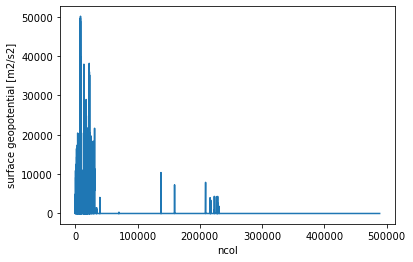

In [238]:
ds_topo['PHIS'].plot()

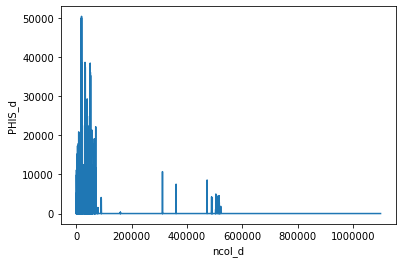

In [239]:
ds_topo['PHIS_d'].plot()

In [ ]:
# templated info ...
"""
------------------------------
cime_config/config_grids.xml
------------------------------

    <model_grid alias="enax32v2pg2_r05_oRRS18to6v3">
      <grid name="atm">ne0np4_enax32v2.pg2</grid>
      <grid name="lnd">r05</grid>
      <grid name="ocnice">oRRS18to6v3</grid>
      <grid name="rof">r05</grid>
      <grid name="glc">null</grid>
      <grid name="wav">null</grid>
      <mask>oRRS18to6v3</mask>
    </model_grid>

    <domain name="ne0np4_enax32v2.pg2">
      <nx>488624</nx>
      <ny>1</ny>
      <file grid="atm|lnd" mask="oRRS18to6v3">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.211210.nc</file>
      <file grid="ice|ocn" mask="oRRS18to6v3">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.211210.nc</file>
      <desc>1-deg with ne1024pg2 over Eastern North Atlantic (version 0 test):</desc>
    </domain>

    <gridmap atm_grid="ne0np4_enax32v2.pg2" ocn_grid="oRRS18to6v3">
      <map name="ATM2OCN_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_mono.20211209.nc</map>
      <map name="ATM2OCN_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_bilin.20211209.nc</map>
      <map name="ATM2OCN_VMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_oRRS18to6v3_bilin.20211209.nc</map>
      <map name="OCN2ATM_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211209.nc</map>
      <map name="OCN2ATM_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_oRRS18to6v3_to_enax32v2pg2_mono.20211209.nc</map>
    </gridmap>                                                                                                                                                               
                                                                                                                                                                             
    <gridmap atm_grid="ne0np4_enax32v2.pg2" lnd_grid="r05">
      <map name="ATM2LND_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_mono.20211209.nc</map>
      <map name="ATM2LND_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_bilin.20211209.nc</map>
      <map name="LND2ATM_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_r05_to_enax32v2pg2_mono.20211209.nc</map>
      <map name="LND2ATM_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_r05_to_enax32v2pg2_mono.20211209.nc</map>
    </gridmap>

    <gridmap atm_grid="ne0np4_enax32v2.pg2" rof_grid="r05">
      <map name="ATM2ROF_FMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_mono.20211209.nc</map>
      <map name="ATM2ROF_SMAPNAME">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/map_enax32v2pg2_to_r05_mono.20211209.nc</map>
    </gridmap>
    
-------------------------------------------------
components/eam/bld/config_files/horiz_grid.xml
-------------------------------------------------
<horiz_grid dyn="se" hgrid="ne0np4_enax32v2.pg2"              ncol="488624" csne="0" csnp="4" npg="2" />


-------------------------------------------------------------
components/eam/bld/namelist_files/namelist_defaults_eam.xml
-------------------------------------------------------------
<dtime dyn="se"    hgrid="ne0np4_enax32v2.pg2">900</dtime>
<ncdata dyn="se" hgrid="ne0np4_enax32v2.pg2" nlev="72">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/HICCUP.atm_era5.2017-07-18.enax32v2pg2.L72.nc</ncdata>
<bnd_topo hgrid="ne0np4_enax32v2" npg="2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/USGS-gtopo30_enax32v2pg2_12xdel2.nc</bnd_topo>
<drydep_srf_file hgrid="ne0np4_enax32v2" npg="2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/atmsrf_enax32v2pg2_20211209.nc</drydep_srf_file>
<se_ne hgrid="ne0np4_enax32v2">0</se_ne>
<mesh_file hgrid="ne0np4_enax32v2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/enax32v2.g</mesh_file>
<nu_top dyn_target="theta-l" hgrid="ne0np4_enax32v2"> 1e5 </nu_top>
<se_tstep dyn_target="theta-l" hgrid="ne0np4_enax32v2"> 75 </se_tstep>
<hypervis_subcycle dyn_target="theta-l" hgrid="ne0np4_enax32v2"  > 2 </hypervis_subcycle>
<nu dyn_target="preqx" hgrid="ne0np4_enax32v2">8.0e-8</nu>
<nu_div dyn_target="preqx" hgrid="ne0np4_enax32v2">20.0e-8</nu_div>
<hypervis_scaling dyn_target="preqx" hgrid="ne0np4_enax32v2">3.2</hypervis_scaling>
<se_nsplit dyn_target="preqx" hgrid="ne0np4_enax32v2">4</se_nsplit>
<hypervis_subcycle hgrid="ne0np4_enax32v2" dyn_target="preqx">7</hypervis_subcycle>
<fatmlndfrc hgrid="ne0np4_enax32v2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.lnd.enax32v2pg2_oRRS18to6v3.211210.nc</fatmlndfrc>
<focndomain hgrid="ne0np4_enax32v2">/global/cscratch1/sd/crjones/e3sm/grids/enax32v2pg2/domain.ocn.enax32v2pg2_oRRS18to6v3.211210.nc</focndomain>

"""